# COGS 118C Final Project


In [23]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.stats import ttest_ind
from scipy.signal import spectrogram



In [24]:
Control = np.load("EEG_human/Control_EEG_sub_037.npy")
AD = np.load("EEG_human/AD_EEG_sub_001.npy")

In [25]:
processed_Control = np.load("EEG_human/Control_EEG_sub_037_processed.npy")
processed_AD = np.load("EEG_human/AD_EEG_sub_001_processed.npy")

In [26]:
fs = 500  # Sampling rate (Hz)

In [27]:
from scipy.signal import iirnotch, filtfilt

def notch_filter(data, notch_freq=60, fs=500, quality_factor=30):
    """Apply a notch filter at 60 Hz to remove powerline interference."""
    b, a = iirnotch(notch_freq, quality_factor, fs)
    return filtfilt(b, a, data)

# Apply the notch filter to each EEG channel
filtered_Control = np.array([notch_filter(channel, fs=500) for channel in processed_Control])
filtered_AD = np.array([notch_filter(channel, fs=500) for channel in processed_AD])

In [28]:
from scipy.signal import butter, filtfilt

def bandpass_filter(data, lowcut=1, highcut=30, fs=500, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Apply filter to each EEG channel
filtered1_Control = np.array([bandpass_filter(channel) for channel in filtered_Control])
filtered1_AD = np.array([bandpass_filter(channel) for channel in filtered_AD])

## Power spectrum

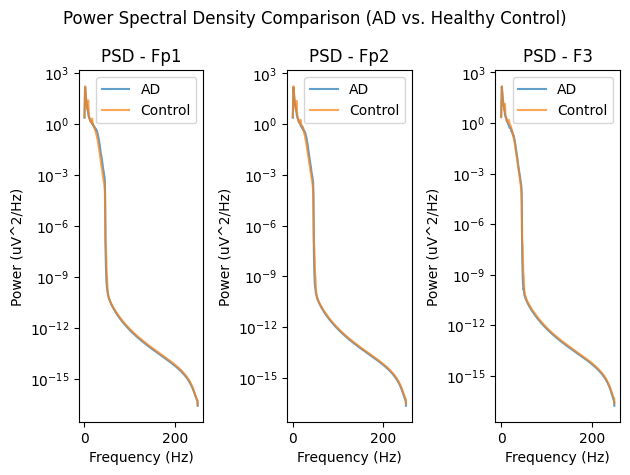

In [29]:
bands = { "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 100), }

for i, channel in enumerate(["Fp1", "Fp2", "F3"]):
    # Compute PSD using Welch's method
    f_ad, psd_ad = welch(filtered1_AD[i], fs, nperseg=fs*2)
    f_control, psd_control = welch(filtered1_Control[i], fs, nperseg=fs*2)

    # Plot
    plt.subplot(1, 3, i + 1)
    plt.semilogy(f_ad, psd_ad, label="AD", alpha=0.7)
    plt.semilogy(f_control, psd_control, label="Control", alpha=0.7)
    plt.title(f"PSD - {channel}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (uV^2/Hz)")
    plt.legend()

plt.suptitle("Power Spectral Density Comparison (AD vs. Healthy Control)")
plt.tight_layout()
plt.show()

In [30]:
# Function to compute relative power in different EEG bands
def compute_band_power(psd, freqs, bands):
    band_power = {}
    total_power = np.trapz(psd, freqs)  # Total power across all frequencies

    for band, (low, high) in bands.items():
        idx_band = np.logical_and(freqs >= low, freqs <= high)
        band_power[band] = np.trapz(psd[idx_band], freqs[idx_band]) / total_power  # Relative power

    return band_power

# Compute relative power for each channel and group
band_powers_ad = {ch: compute_band_power(*welch(filtered1_AD[i], fs, nperseg=fs*2), bands) 
                  for i, ch in enumerate(["Fp1", "Fp2", "F3"])}
band_powers_control = {ch: compute_band_power(*welch(filtered1_Control[i], fs, nperseg=fs*2), bands) 
                       for i, ch in enumerate(["Fp1", "Fp2", "F3"])}

df_ad = pd.DataFrame(band_powers_ad).T
df_control = pd.DataFrame(band_powers_control).T

# Add group labels
df_ad["Group"] = "AD"
df_control["Group"] = "Control"

# Combine both dataframes
df_power_comparison = pd.concat([df_ad, df_control])
df_power_comparison

,Delta,Theta,Alpha,Beta,Gamma,Group
Fp1,0.108948,0.066847,0.033675,0.166032,0.492383,AD
Fp2,0.105149,0.072710,0.030165,0.159011,0.499423,AD
F3,0.102565,0.067465,0.027848,0.206443,0.466153,AD
Fp1,0.092947,0.049236,0.000827,-0.078793,0.304804,Control
Fp2,0.089472,0.066543,0.009659,-0.067922,0.294487,Control
F3,0.100296,0.009765,-0.036422,0.098885,0.459604,Control


In [31]:
# Perform t-tests for each frequency band
t_test_results = {}
for band in bands.keys():
    ad_values = df_ad[band].values
    control_values = df_control[band].values
    t_stat, p_value = ttest_ind(ad_values, control_values, equal_var=False)
    t_test_results[band] = {"T-statistic": t_stat, "P-value": p_value}

# Convert results to a dataframe
df_t_tests = pd.DataFrame(t_test_results).T
df_t_tests

,T-statistic,P-value
Delta,3.066549,0.050013
Theta,1.606683,0.246430
Alpha,2.756920,0.106887
Beta,3.252621,0.070242
Gamma,2.447342,0.125785


Spectrogram

In [32]:
from scipy.signal import butter, filtfilt

# Bandpass filter function (e.g., 1-50 Hz)
def bandpass_filter(data, lowcut=1, highcut=50, fs=1000, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Apply filtering
filtered2_Control = bandpass_filter(filtered1_Control)
filtered2_AD = bandpass_filter(filtered1_AD)

In [33]:
# Z-score normalization
def zscore_normalize(data):
    return (data - np.mean(data)) / np.std(data)

# Apply normalization
normalized_Control = zscore_normalize(filtered2_Control)
normalized_AD = zscore_normalize(filtered2_AD)

Control Sxx shape: (3, 129, 669)
AD Sxx shape: (3, 129, 669)


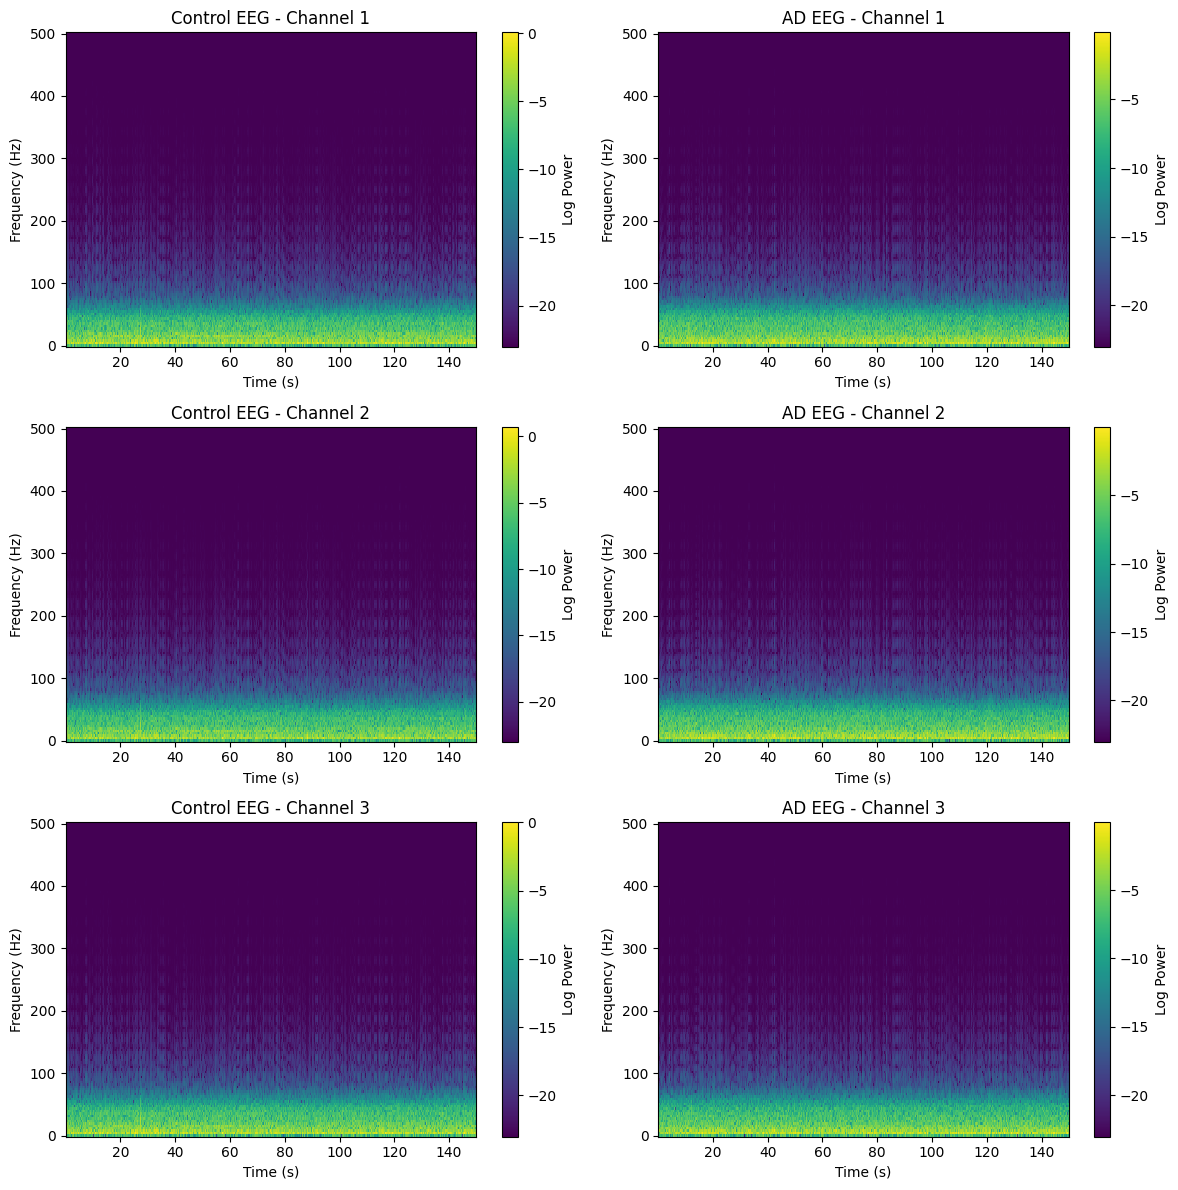

In [34]:
# Define parameters
fs = 1000  # Sampling frequency (adjust as needed)

# Compute spectrograms for Control and AD
frequencies, times, Sxx_control = spectrogram(normalized_Control, fs=fs, nperseg=256)
_, _, Sxx_ad = spectrogram(normalized_AD, fs=fs, nperseg=256)  # Compute AD spectrogram

# Debugging: Print shapes
print("Control Sxx shape:", Sxx_control.shape)  # Should be (3, 129, 669)
print("AD Sxx shape:", Sxx_ad.shape)  # Should be (3, 129, 669)

# Number of EEG channels
num_channels = Sxx_control.shape[0]

# Create figure for side-by-side comparison
fig, axs = plt.subplots(num_channels, 2, figsize=(12, 4 * num_channels))

for i in range(num_channels):
    # Control Spectrogram
    ax1 = axs[i, 0] if num_channels > 1 else axs[0]
    pcm1 = ax1.pcolormesh(times, frequencies, np.log(Sxx_control[i] + 1e-10), shading='auto')
    ax1.set_ylabel('Frequency (Hz)')
    ax1.set_xlabel('Time (s)')
    ax1.set_title(f'Control EEG - Channel {i+1}')
    fig.colorbar(pcm1, ax=ax1, label='Log Power')

    # AD Spectrogram
    ax2 = axs[i, 1] if num_channels > 1 else axs[1]
    pcm2 = ax2.pcolormesh(times, frequencies, np.log(Sxx_ad[i] + 1e-10), shading='auto')
    ax2.set_ylabel('Frequency (Hz)')
    ax2.set_xlabel('Time (s)')
    ax2.set_title(f'AD EEG - Channel {i+1}')
    fig.colorbar(pcm2, ax=ax2, label='Log Power')

plt.tight_layout()
plt.show()


In [35]:
import numpy as np
from scipy.signal import spectrogram

# Define EEG frequency bands
BANDS = {
    "Delta": (1, 4),
    "Theta": (4, 7),
    "Alpha": (8, 13),
    "Beta": (13, 30)
}

# Compute spectrograms for Control and AD
fs = 1000  # Sampling frequency
frequencies, times, Sxx_control = spectrogram(normalized_Control, fs=fs, nperseg=256)
_, _, Sxx_ad = spectrogram(normalized_AD, fs=fs, nperseg=256)

# Function to extract band power
def extract_band_power(Sxx, freqs, band):
    """Compute the average power in a given frequency band."""
    f_min, f_max = BANDS[band]
    band_indices = np.where((freqs >= f_min) & (freqs <= f_max))[0]
    return np.mean(Sxx[:, band_indices, :], axis=1)  # Averaging over frequencies

# Extract power for each band
band_power_control = {band: extract_band_power(Sxx_control, frequencies, band) for band in BANDS}
band_power_ad = {band: extract_band_power(Sxx_ad, frequencies, band) for band in BANDS}


/Users/yifanlou/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yifanlou/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/Users/yifanlou/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


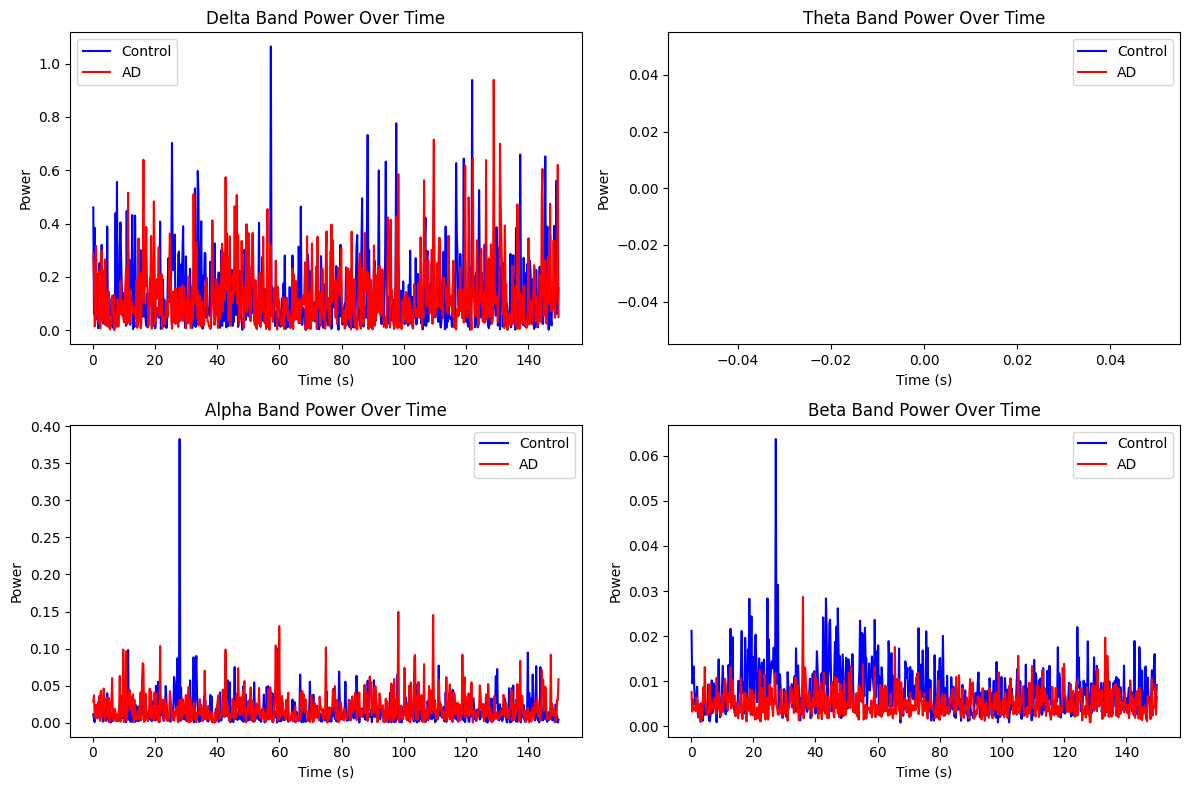

In [36]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, (band, power_control) in enumerate(band_power_control.items()):
    power_ad = band_power_ad[band]
    
    ax = axs[i // 2, i % 2]  # Arrange in a 2x2 grid
    ax.plot(times, np.mean(power_control, axis=0), label="Control", color='blue')
    ax.plot(times, np.mean(power_ad, axis=0), label="AD", color='red')
    ax.set_title(f"{band} Band Power Over Time")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Power")
    ax.legend()

plt.tight_layout()
plt.show()


In [37]:
from scipy.stats import ttest_ind

for band in BANDS:
    t_stat, p_value = ttest_ind(np.mean(band_power_control[band], axis=1),
                                np.mean(band_power_ad[band], axis=1))

    print(f"{band} Band: t = {t_stat:.2f}, p = {p_value:.4f}")


Delta Band: t = 0.44, p = 0.6830
Theta Band: t = nan, p = nan
Alpha Band: t = -3.61, p = 0.0226
Beta Band: t = 2.81, p = 0.0481
